# Logistic regression model for fair recidivism prediction tasks.

#### COMPAS dataset

This dataset is used to assess the likelihood that a criminal defendant will re-offend.

##### Aim 1: to make a logistic regression model using this dataset 

##### and to get the predictions, ground truth values, and protected vs non protected attributes.

#### Prediction Objective: 
Estimate the target variable 'recidivism outcome', which is either 'Did recid' or 'No recid' for each set of input features.

In [4]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt



pip install 'aif360[inFairness]'


##### Note: The label value 0 in this case is considered favorable (no recidivism).

In [5]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd


#load COMPAS dataset

try:
    compas = CompasDataset(
        protected_attribute_names=['sex', 'race'],
        privileged_classes=[['Female'], ['Caucasian']], 
        features_to_keep=['age', 'c_charge_degree', 'race', 'age_cat', 
                          'sex', 'priors_count', 'days_b_screening_arrest', 'c_charge_desc'],
        features_to_drop=[],
        categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc'],
        label_name='two_year_recid'
    )
    print("Dataset loaded successfully!")

    #returns the dataframe and the metadata in a tuple
    df, meta = compas.convert_to_dataframe()

except Exception as e:
    print(f"Error loading COMPAS dataset: {e}")


print("compas object type:", type(compas))
#print("Dataframe for compas dataset:", df.head())
#print("show columns and data types for dataframe: ", df.info)


Dataset loaded successfully!
compas object type: <class 'aif360.datasets.compas_dataset.CompasDataset'>


#### Label names mapping and Protected attribute mappings

In [6]:
print("label names: ", compas.metadata['label_maps'])
print("Protected attributes: ", compas.metadata['protected_attribute_maps'])

label names:  [{1.0: 'Did recid.', 0.0: 'No recid.'}]
Protected attributes:  [{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]


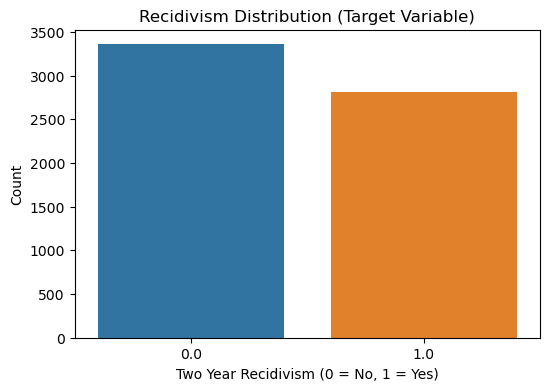

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['two_year_recid'])
plt.title("Recidivism Distribution (Target Variable)")
plt.xlabel("Two Year Recidivism (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


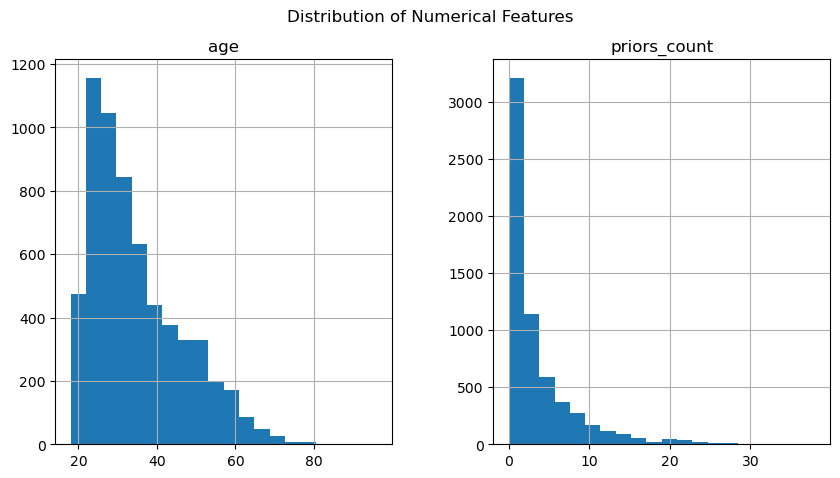

In [8]:
df[['age', 'priors_count']].hist(figsize=(10,5), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()

### Below is information on protected attributes 'race' and 'sex'

To show binary mappings and an idea of the distribution of data / imbalance in data

Not Caucasian (unprivileged) = 0.0, Caucasian (privileged) = 1.0: 
race
0.0    4067
1.0    2100
Name: count, dtype: int64 

Male (unprivileged) = 0.0, Female (privileged) = 1.0: 
sex
0.0    4994
1.0    1173
Name: count, dtype: int64 



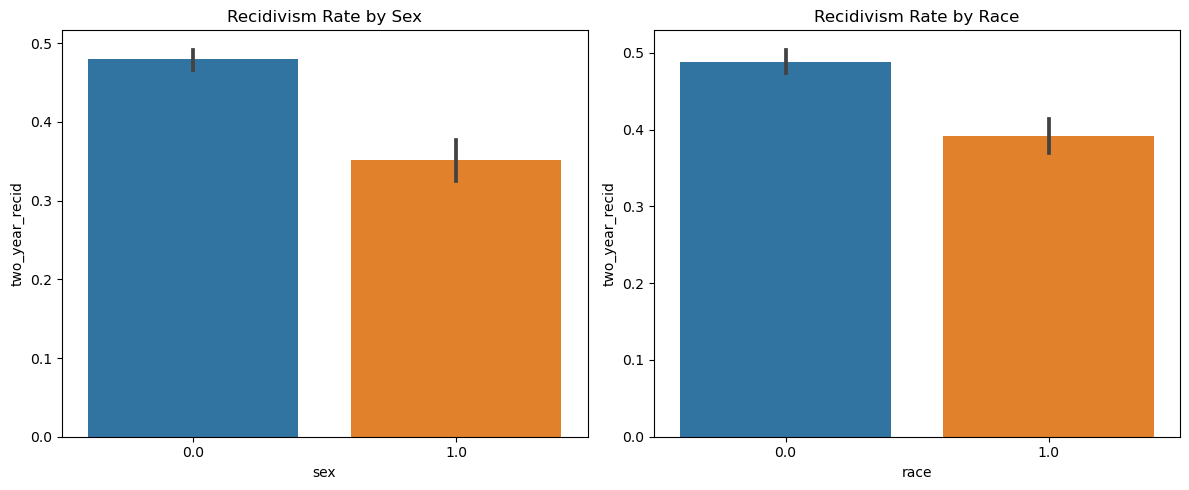

In [45]:
#to check the features that the dataset contains
#print(df.columns)

# distribution of race
print("Not Caucasian (unprivileged) = 0.0, Caucasian (privileged) = 1.0: ")
print(df['race'].value_counts(), "\n")

# distribution of sex
print("Male (unprivileged) = 0.0, Female (privileged) = 1.0: ")
print(df['sex'].value_counts(), "\n")   

plt.figure(figsize=(12,5))

# Sex vs. Recidivism
plt.subplot(1,2,1)
sns.barplot(x='sex', y='two_year_recid', data=df)
plt.title("Recidivism Rate by Sex")

# Race vs. Recidivism
plt.subplot(1,2,2)
sns.barplot(x='race', y='two_year_recid', data=df)
plt.title("Recidivism Rate by Race")

plt.tight_layout()
plt.show()




## Training a logistic regression model on the COMPAS dataset

1. Define features and target
2. Create a train/test split
3. standardise the data
4. train the LR model

In [43]:
# copy dataset to ensure original remains unchanged
df = df.copy()

#print(df.columns)

#separate features and labels
features = ['race', 'sex', 'priors_count', 'c_charge_degree=F', 'c_charge_degree=M']
target = 'two_year_recid' #binary target where 0 means does not offend, 1 means offends

X = df[features]
y = df[target]
#print(X.shape)
#print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#print(X_train[:5])
#print("\n", y_train)

print("What X_test contains:  ", "\n", X_test)

X_test_indices = X_test.index
print(X_test_indices)

#retrive each instance's group membership before scaling X_test to make predictions 
#scaling will make it lose the index information to retrieve this information
grp_membership = df.loc[X_test_indices, 'race'].values
print("\n group membership: ", grp_membership, "\n")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train_scaled, y_train)

#predicted class labels 0 or 1
y_pred = model.predict(X_test_scaled)

#there are two classes my model is predicting - negative and positive
#print(model.classes_)

#to see how many negative and postive labels are being predicted
#get indexes of neg and pos predictions 
negative_indexes = np.where(y_pred == 0)[0]  
positive_indexes = np.where(y_pred == 1)[0]

#extract the values of the prediction using those indices
negative_predictions = y_pred[negative_indexes]  
positive_predictions = y_pred[positive_indexes]  

#get the total number of predictions for each class
print(f"Negative Predictions (0s): {len(negative_predictions)}")
print(f"Positive Predictions (1s): {len(positive_predictions)}")


What X_test contains:   
        race  sex  priors_count  c_charge_degree=F  c_charge_degree=M
630     1.0  0.0           0.0                1.0                0.0
9785    1.0  0.0           0.0                0.0                1.0
10969   0.0  0.0           2.0                0.0                1.0
2927    0.0  0.0           7.0                1.0                0.0
10148   0.0  0.0          11.0                0.0                1.0
...     ...  ...           ...                ...                ...
2078    1.0  0.0           4.0                1.0                0.0
4950    0.0  0.0           0.0                1.0                0.0
5745    0.0  0.0           2.0                1.0                0.0
7808    0.0  0.0           2.0                1.0                0.0
5532    0.0  1.0           0.0                0.0                1.0

[1234 rows x 5 columns]
Index(['630', '9785', '10969', '2927', '10148', '6179', '1907', '10519', '818',
       '9358',
       ...
       '7635', 

#### Task 1: Three input arrays for new_metric function

To do: take out each of those three aspects and have 3 arrays each.
Important aspect of this part: indices of each array needs to align such that pred[0] refers to ground_truth[0] and grp_membership[0]. 


In [49]:
#print(compas.__dict__) #show all attributes of the object

#put predictions in an array 
predictions = y_pred 
print("predictions: ", predictions)

#array of GT labels of classification task 
#this is the two_yr_recid column that represents the target variables
#so use y_test which contains ground truth values from the train_test_split for the dataset

ground_truth = y_test.values 
print("ground truth labels: ", ground_truth)

#array of group membership - protected vs non protected or did he mean privileged vs non priv
print("group membership: ", grp_membership)
print("Note: race is the protected attribute that has 1 and 0 labels for privileged (Caucasian) and unprivileged (not Caucasian) classes.")

predictions:  [0. 0. 0. ... 0. 0. 0.]
ground truth labels:  [0. 0. 1. ... 0. 1. 1.]
group membership:  [1. 1. 0. ... 0. 0. 0.]
Note: race is the protected attribute that has 1 and 0 labels for privileged (Caucasian) and unprivileged (not Caucasian) classes.


#### Task 2: Coding the new metric using the three arrays as input.

In [2]:
def new_metric(arr_pred, arr_true, arr_grp): #varying these three for diff distri- protected groups can be diff sizes, edge cases 50 TP/50 TN, 10/90
    #need 2 arrays for protected and non  protected 
    #g1 - predictions and trues are lists of lists [[], []]
    #g2 - same as g1

    #this is for what you need for GEI calculation

    #for each index calcylate benefit 
    #+= total benefit of group
    #divide by size of group - result of this is for each class 
    # same for g2
    #division result is divided by the sum of g1 and g2 - J

    #return result, indiv benefit, etc in case we need to use later

#results from this from classification 
#do a comparison from this and existing evaluation metrics in AIF360 - have a table of metric value cloumns and have indiv comp of your metric in a colum and existing metrcis 
    #each test case a diff row in table

#find method of evaluation that highlight benefits of doing this 
#can simulate classification results for edge cases - classifier foes good on one group and not on other
    #creating arrays with different distrubutions. 
    #wanting to see that my metric gives more intuitive etc results
#test cases where classifiers act differently 

#classifier level group metric that takes into consideration individual components - basic starting point

SyntaxError: incomplete input (3871007210.py, line 26)

In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6337115072933549
Balanced Accuracy: 0.6151949881376038
Confusion Matrix:
 [[553 119]
 [333 229]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.82      0.71       672
         1.0       0.66      0.41      0.50       562

    accuracy                           0.63      1234
   macro avg       0.64      0.62      0.61      1234
weighted avg       0.64      0.63      0.62      1234



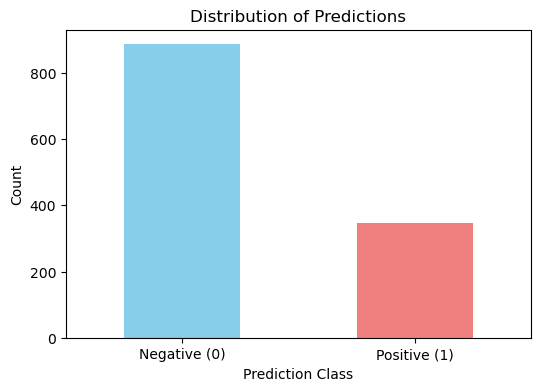

In [68]:
# Plot the distribution of positive and negative predictions
plt.figure(figsize=(6, 4))
pd.Series(y_pred).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Distribution of Predictions")
plt.xlabel("Prediction Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'], rotation=0)
plt.show()

In [69]:
print(y.value_counts())

two_year_recid
0.0    3358
1.0    2809
Name: count, dtype: int64
